# Project 3 - Detecting Pneumonia from X-ray Images

### 1. Introduction & Objectives

In this notebook, we will build a Convolutional Neural Network (CNN) to detect Pneumonia from X-ray images.

### 2. Data Understanding

The dataset consists of 5,856 X-Ray images in JPEG format. The images are all different sizes, so we will resize them to 224x224 pixels. The dataset is divided into three subdirectories: `train`, `val`, and `test`. Each of the subdirectories are further divided into two subdirectories: `NORMAL` and `PNEUMONIA`. The `train` directory contains a total of 5,216 images, of which 3,875 are Pneumonia images and 1,341 are Normal images. The `val`directory contains a total of 16 images, of which 8 are Pneumonia images and 8 are Normal images. The `test` directory contains a total of 624 images, of which 390 are Pneumonia images and 234 are Normal images.

#### 2.1 Environment Setup

To streamline this notebook, we will supress TensorFlow warnings, and set the Keras backend to TensorFlow. We will also provide a way to disable the GPU. Just set the flag `use_gpu` to `False` to disable the GPU.

In [1]:
# Supress TensorFlow warnings and set the Keras backend to TensorFlow
import os
import sys

os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Redirect stderr to null
sys.stderr = open(os.devnull, 'w')

# Set the flag to disable the GPU
use_gpu = True

In [2]:
if not use_gpu:
    # Disable the GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = ''

    print("GPU is disabled.")
else:
    # Set the GPU device
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'

    # Optimize GPU memory allocation
    os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

    # Enable XLA JIT compilation
    os.environ["TF_XLA_FLAGS"] = "--tf_xla_enable_xla_devices"

    # Disable unnecessary logging
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

    # Maximize GPU usage
    os.environ["TF_ENABLE_GPU_GARBAGE_COLLECTION"] = "false"

    # Advanced GPU optimizations
    os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
    os.environ["TF_FORCE_UNIFIED_MEMORY"] = "1"
    os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = "1"

    print("GPU is enabled.")

GPU is enabled.


The environment is now set up. We can proceed to importing the libraries we will be using

#### 2.2 Importing Libraries

We will import the libraries we will be using in this notebook.

In [17]:
# Importing Libraries
import numpy as np
import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt
from keras.src.optimizers import Adam
from keras.api.regularizers import l2
from keras.api.models import load_model
from sklearn.utils import compute_class_weight
from keras.src import Sequential, Input, Model
from keras.src.callbacks import ModelCheckpoint
from keras.src.utils import image_dataset_from_directory
from keras.src.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.api.layers import RandomFlip, RandomZoom, RandomRotation
from keras.src.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

The libraries have been imported. We can now proceed to loading the data.

#### 2.3 Loading the Data

We will load the data from the `Inputs\chest_xray` directory. The data is in subdirectories `train`, `val`, and `test`.

In [4]:
# Load the data
base_dir = Path('../Inputs/chest_xray')

train_dataset = image_dataset_from_directory(base_dir / 'train', labels='inferred', label_mode='categorical',
                                             batch_size=32, image_size=(224, 224))
val_dataset = image_dataset_from_directory(base_dir / 'val', labels='inferred', label_mode='categorical', batch_size=32,
                                           image_size=(224, 224))
test_dataset = image_dataset_from_directory(base_dir / 'test', labels='inferred', label_mode='categorical',
                                            batch_size=32, image_size=(224, 224))

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


The data has been loaded. We can now proceed to analyzing the class distribution.

#### 2.4 Analyzing the Class Distribution

We will analyze the class distribution of the training dataset.

In [5]:
# Analyze the class distribution
class_counts = {}

for _, labels in train_dataset.unbatch():
    label = np.argmax(labels.numpy())
    class_counts[label] = class_counts.get(label, 0) + 1

print("Class distribution:", class_counts)

Class distribution: {1: 3875, 0: 1341}


The training dataset has 3,875 Pneumonia images and 1,341 Normal images. As we can see, the training dataset is imbalanced. We will now compute the class weights to balance the dataset during training.

In [6]:
# Extract and flatten labels from the dataset
all_labels = []

for _, labels in train_dataset.unbatch():
    all_labels.append(np.argmax(labels.numpy(), axis=-1))

all_labels = np.array(all_labels)

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(all_labels),
    y=all_labels
)

class_weights = dict(enumerate(class_weights))
print(f"Class weights: {class_weights}")

Class weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


The class weights have been computed. Here the class 0 is `Normal` and class 1 is `Pneumonia`. The class weights are used to balance the model training, so it's not biased towards the majority class. We can now check the image sizes.

#### 2.5 Checking the Image Sizes

We will check if the images are of the same size.

In [7]:
# Check if the images are of the same size
for images, _ in train_dataset.take(1):
    print("Image sizes:", images.shape)

Image sizes: (32, 224, 224, 3)


The images are of the same size. We can now visualize the data.

#### 2.6 Visualizing the Data

We will visualize some of the samples from the training dataset.

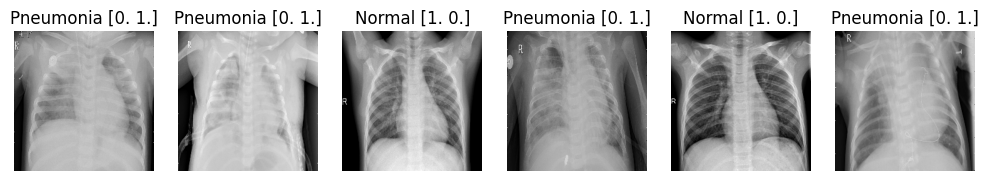

In [8]:
plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):
    for i in range(6):
        plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Normal {labels[i]}" if np.argmax(labels[i]) == 0 else f"Pneumonia {labels[i]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

The label [0, 1] indicates Pneumonia, while [1, 0] indicates Normal. The data has been visualized. We can now proceed to preprocessing the data.

#### 2.7 Preprocessing the Data

We will preprocess the data by normalizing the pixel values.

In [9]:
# Preprocess the data
train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x), y))
val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x), y))
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y))

The data has been preprocessed. We can now check the pixel range after normalization.

In [10]:
for images, labels in train_dataset.take(1):
    print(f"Pixel range after normalization: {tf.reduce_min(images).numpy()} to {tf.reduce_max(images).numpy()}")

Pixel range after normalization: 0.0 to 255.0


The pixel values have been normalized. We can now proceed to building the model.

### 3. Model Building

We will build a Convolutional Neural Network (CNN) using the EfficientNetV2 architecture, since it's state of the art and provides better performance than VGG16 in medical imaging tasks. We will also add a few more layers to the model.

#### 3.1 Data Augmentation

We will perform data augmentation on the training dataset. We will randomly flip, zoom and rotate the images.

In [11]:
# Data Augmentation
data_augmentation = Sequential(
    [
        RandomFlip('horizontal'),
        RandomRotation(0.1),
        RandomZoom(0.2)
    ],
    name='Data_Augmentation_Layer'
)

We have set up the data augmentation layer. We can now build the model.

#### 3.2 Building the Model

We will build a Convolutional Neural Network (CNN) using the EfficientNetV2 architecture. We will also add a few more layers to the model.

In [12]:
# Loading the pre-trained EfficientNetV2B0 model
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Input layer
inputs = Input(shape=(224, 224, 3))

# Model layers
x = data_augmentation(inputs)
x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)

# Output layer for binary classification
outputs = Dense(2, activation='softmax')(x)

# Create the model
model = Model(inputs, outputs, name='Pneumonia_Detection_Model')

# Show the model summary
model.summary()

Model: "Pneumonia_Detection_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Data_Augmentation_Layer         │ (None, 224, 224, 3)    │             0 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,247,762 (23.83 MB)

 Trainable params: 328,450 (1.25 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

The model has been built. The model has a total of **6,247,762** parameters, of which **328,450** are trainable. We can now compile and train the model.

#### 3.3 Compiling and Training the Model

We will compile the model using the Adam optimizer and the class weights we computed earlier. We will also save the best model using the `ModelCheckpoint` callback.

In [13]:
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall']
)

# Define the callbacks
callbacks = [
    ModelCheckpoint(
        filepath="../Models/Chest_X-Ray_Pneumonia_Detection_Model.keras",
        save_best_only=True,
        monitor="val_loss",
        verbose=1
    )
]

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/30

Epoch 1: val_loss improved from inf to 3.30567, saving model to ../Models/Chest_X-Ray_Pneumonia_Detection_Model.keras
163/163 - 23s - 143ms/step - Precision: 0.8004 - Recall: 0.8004 - accuracy: 0.8004 - loss: 3.9552 - val_Precision: 0.6875 - val_Recall: 0.6875 - val_accuracy: 0.6875 - val_loss: 3.3057
Epoch 2/30

Epoch 2: val_loss improved from 3.30567 to 2.26749, saving model to ../Models/Chest_X-Ray_Pneumonia_Detection_Model.keras
163/163 - 9s - 56ms/step - Precision: 0.8930 - Recall: 0.8930 - accuracy: 0.8930 - loss: 2.6452 - val_Precision: 0.8125 - val_Recall: 0.8125 - val_accuracy: 0.8125 - val_loss: 2.2675
Epoch 3/30

Epoch 3: val_loss improved from 2.26749 to 1.69297, saving model to ../Models/Chest_X-Ray_Pneumonia_Detection_Model.keras
163/163 - 9s - 54ms/step - Precision: 0.9080 - Recall: 0.9080 - accuracy: 0.9080 - loss: 1.8755 - val_Precision: 0.8125 - val_Recall: 0.8125 - val_accuracy: 0.8125 - val_loss: 1.6930
Epoch 4/30

Epoch 4: val_loss improved from 1.69297

The model has been compiled and trained. Epoch 27 was the best epoch. Results:

- Precision: 0.9440
- Recall: 0.9440
- Accuracy: 0.9440
- Loss: 0.2225

Validation results:

- Precision: 0.9375
- Recall: 0.9375
- Accuracy: 0.9375
- Loss: 0.2138

### 4. Model Evaluation

We can now evaluate the model on the test dataset. Before that, we will first visualize the training and validation metrics.

#### 4.1 Visualizing the Training Metrics

We will visualize the training and validation accuracy and loss by plotting the metrics.

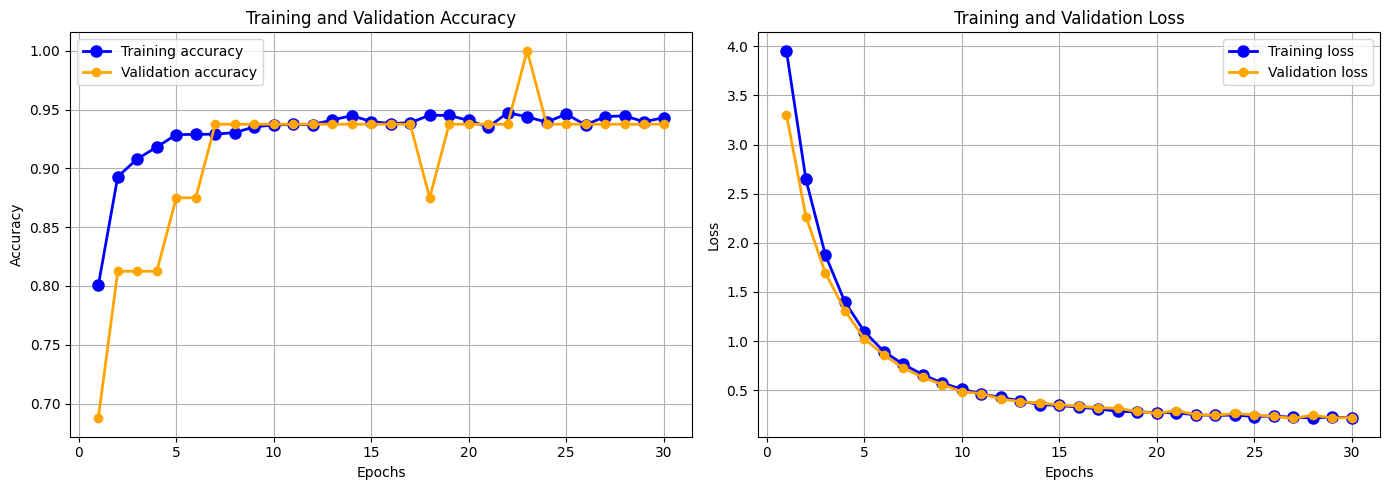

In [14]:
# Extracting data from the new model's history
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(accuracy) + 1)

# Create subplots with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot accuracy on the first subplot (left) with blue and orange colors
ax1.plot(epochs, accuracy, marker="o", linestyle="-", label="Training accuracy", markersize=8, linewidth=2,
         color="blue")
ax1.plot(epochs, val_accuracy, marker="o", linestyle="-", label="Validation accuracy", linewidth=2, color="orange")
ax1.set_title("Training and Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(True)

# Plot loss on the second subplot (right) with blue and orange colors
ax2.plot(epochs, loss, marker="o", linestyle="-", label="Training loss", markersize=8, linewidth=2, color="blue")
ax2.plot(epochs, val_loss, marker="o", linestyle="-", label="Validation loss", linewidth=2, color="orange")
ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

The training and validation metrics have been visualized. We can now evaluate the model on the test dataset.

#### 4.2 Evaluating the Model

We will load the best model and evaluate it on the test dataset.

In [16]:
# Load the best model
model = load_model("../Models/Chest_X-Ray_Pneumonia_Detection_Model.keras")

# Evaluate the model on the test dataset
loss, accuracy, precision, recall = model.evaluate(test_dataset, verbose=0)

# Print the evaluation metrics
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, Accuracy: {accuracy * 100:.2f}%, Loss: {loss:.4f}")

Precision: 0.8782, Recall: 0.8782, Accuracy: 87.82%, Loss: 0.3799


The model has been evaluated on the test dataset. The results are:

Precision: 0.8782, Recall: 0.8782, Accuracy: 87.82%, Loss: 0.3799

Let's take a look at some of the incorrectly classified images.

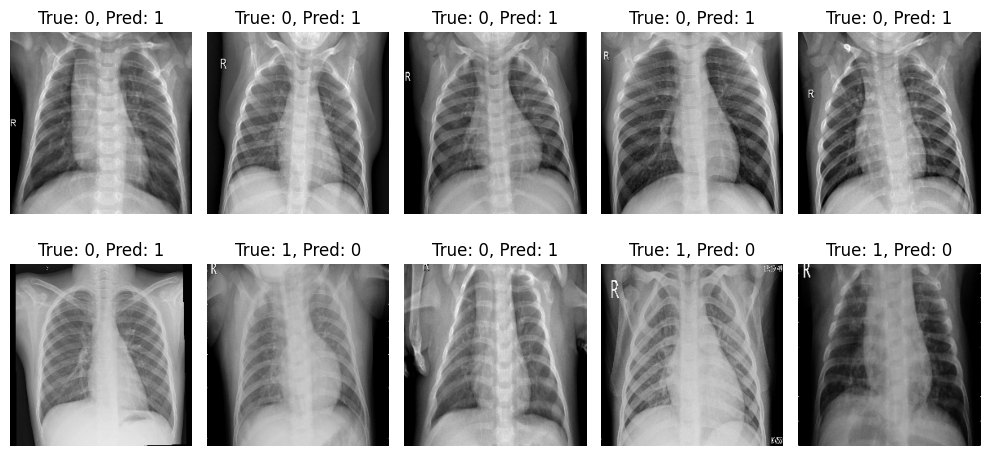

In [29]:
# Get the predictions from the model
predictions = model.predict(test_dataset, verbose=0)

# Convert probabilities to binary labels (0 or 1)
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels and images from the dataset
true_labels = []
images = []

for image_batch, label_batch in test_dataset:
    images.extend(image_batch.numpy())  # Collect images
    true_labels.extend(label_batch.numpy())  # Collect true labels

# Convert true labels to class indices (from one-hot encoding)
true_labels = np.argmax(true_labels, axis=1)

# Identify misclassified images
wrong_indices = np.where(predicted_labels != true_labels)[0]

# Display some of the wrongly identified images
num_images = min(10, len(wrong_indices))  # Limit to 10 images for display
plt.figure(figsize=(10, 5))

for i, idx in enumerate(wrong_indices[:num_images]):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[idx].astype("uint8"))  # Convert image data to displayable format
    plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

The model has misclassified some images. We can now calculate the F1-Score.

#### 4.3 F1 Score

We will calculate the F1-Score for the model.

In [26]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # True labels
    preds = model.predict(images)  # Predicted probabilities
    y_pred.extend(preds.argmax(axis=1))  # Convert probabilities to class indices

# Convert one-hot encoded labels back to integers
y_true = [label.argmax() for label in y_true]

# Calculate F1-Score
f1 = f1_score(y_true, y_pred)
print(f"F1-Score: {f1:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
F1-Score: 0.9089


The F1-Score is **0.9089**. We can now plot the ROC curve and calculate the AUC.

#### 4.4 ROC Curve and AUC

We will plot the ROC curve and calculate the AUC for the model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


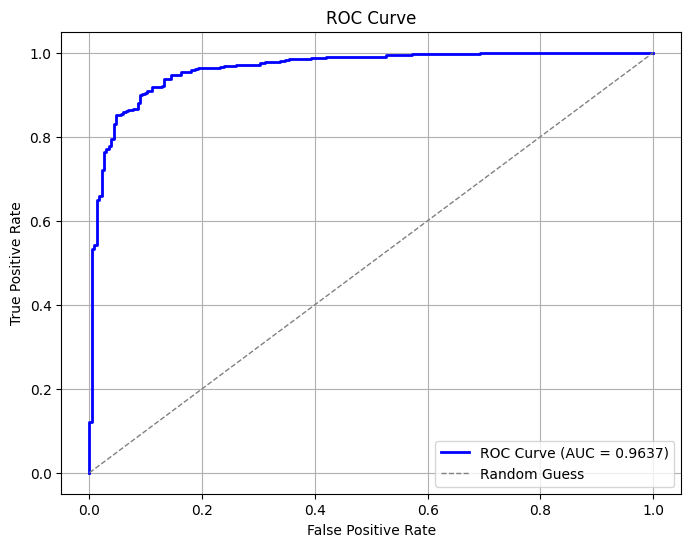

In [23]:
y_true = []
y_probs = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy()[:, 1])  # True labels for the positive class
    preds = model.predict(images)  # Predicted probabilities
    y_probs.extend(preds[:, 1])  # Probability for the positive class

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1, label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

The ROC curve has been plotted, and the AUC is **0.9637**. We can now plot the confusion matrix.

#### 4.5 Confusion Matrix

We will plot the confusion matrix for the model.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


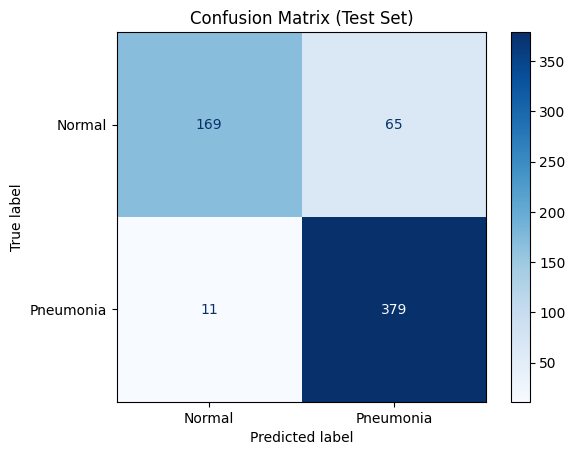

In [27]:
# Get the true labels and predicted probabilities for the test set
y_true = []
y_pred_prob = []

for images, labels in test_dataset:
    y_true.extend(labels.numpy())  # Collect true labels
    y_pred_prob.extend(model.predict(images).tolist())  # Predict probabilities

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Get class predictions
y_pred_classes = np.argmax(y_pred_prob, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal", "Pneumonia"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (Test Set)")
plt.show()

The confusion matrix has been plotted. The model has performed well.

### 5. Medical Insights & Conclusion

The model has been built to detect Pneumonia from X-ray images. The model has achieved an accuracy of **87.82%** on the test dataset. The F1-Score is **0.9089**, and the AUC is **0.9637**. The model has performed well on the test dataset. The confusion matrix shows that the model has correctly classified most of the images.

For real world applications, the model can be used to assist radiologists in diagnosing Pneumonia from X-ray images. The model can help in reducing the workload of radiologists and providing faster diagnosis. However, the model should be used as a tool to assist radiologists, and not as a replacement for expert medical advice.

From an ethical perspective, it is important to ensure that the model is used responsibly and ethically. The model should be used in conjunction with expert medical advice, and the predictions of the model should be verified by a qualified healthcare professional.

Future work can involve improving the model performance by fine-tuning the model architecture, hyperparameters, and data augmentation techniques. The model can also be deployed as a web application or mobile app to make it more accessible to healthcare professionals.

In conclusion, the model has performed well in detecting Pneumonia from X-ray images. The model can be used as a tool to assist radiologists in diagnosing Pneumonia, and can help in providing faster diagnosis and reducing the workload of radiologists.